<a href="https://colab.research.google.com/github/ojimenezn/ml-interpretability/blob/main/interpretability_shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Omar A. Jiménez-Negrón
### May 25, 2020
### ESMA4016 Final Project
## **ML INTERPETABILITY WITH SHAP**



In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost.sklearn import XGBClassifier

In [ ]:
bank = pd.read_csv("https://raw.githubusercontent.com/omarjimenez4/ESMA4016/master/bank-additional-full.csv", sep=";")
y = bank["y"].map({"no":0, "yes":1})
X = bank.drop("y", axis=1)
X.drop("duration", inplace = True, axis = 1)

In [ ]:
bank.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [ ]:
num_features = ["age","campaign","pdays","previous","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]

cat_features = ["job","marital","education","default","housing","loan","contact","month","day_of_week","poutcome"]

In [ ]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

In [ ]:
XGB_model = Pipeline([("preprocessor", preprocessor), 
                      ("model", XGBClassifier(scale_pos_weight=9, n_jobs=-1))])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=42)

In [ ]:
gs = GridSearchCV(XGB_model, {"model__max_depth": [10], "model__min_child_weight": [1],"model__n_estimators": [25]},
                  n_jobs=-1, cv=10, scoring="accuracy")
gs.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)

In [ ]:
y_pred = XGB_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.824957513959699

# SHAP


In [ ]:
!pip install shap

In [ ]:
import shap

Note: We will be using the TreeExplainer class due to its simplicity and accuracy. SHAP also has a model-agnostic class called KernelExplainer, which is the one that relates to LIME, but the latter is more computationally demanding and an approximation!

In [ ]:
explainer = shap.TreeExplainer(XGB_model.named_steps["model"], data = None, feature_perturbation= 'tree_path_dependent')

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
total_instances = XGB_model.named_steps["preprocessor"].transform(X_train.sample(500, random_state=42))
shap_values = explainer.shap_values(total_instances)

In [ ]:
onehot_categories = preprocessor.named_transformers_["categorical"].categories_
new_onehot_features = [f"{col}__{val}" for col, vals in zip(cat_features, onehot_categories) for val in vals]
all_features = num_features + new_onehot_features

In [ ]:
shap.initjs()
i = 6
shap.force_plot(explainer.expected_value, shap_values[i], features=total_instances[i], feature_names=all_features)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, features=total_instances, feature_names=all_features)

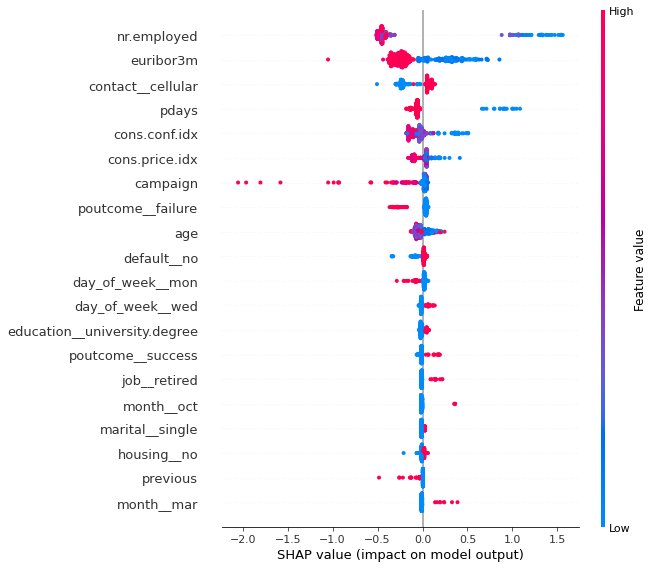

In [ ]:
shap.summary_plot(shap_values, features=total_instances, feature_names=all_features)